# Training a U-Net for accelerated MRI reconstruction 

**Overview.** This notebook provides the code to train a U-Net on each of the datasets used in our experiments. We provide links to our model checkpoints and the purpose of this notebook is to enable reproducing those checkpoints.

The training loss is a normalized $\ell_1$ loss (for the ground-truth $x$ and measurement $Y$): 

$$
L(\theta) = \frac{\|x - f_\theta(A^\dagger Y)\|_1}{\|x\|_1}.
$$


There is a flag ``self`` in the code to incorporate self-supervision during training. If this flag is set to ``True``, then the training loss function turns into:

$$
L(\theta) = \frac{\|x - f_\theta(A^\dagger Y)\|_1}{\|x\|_1} + \frac{\|Y - ASf_\theta(A^\dagger Y)\|_1}{\|Y\|_1}.
$$

Here, $A = MF$ where $M$ is the under-sampling mask and $F$ is the discrete Fourier transform. Moreover, $S$ is the estimated coil sensitivity maps obtained from espirit. 
We optimize this loss function via adam optimizer for 300 epochs.

**Note.** If self-supervision is included in training, then the user needs to provide a directory to the pre-computed coil sensitivity maps. We also provide a function ``compute_sens_maps`` that one can use to compute coil sensitivity maps.

**Note.** The datasets we provide are filename/slice_numbers of the fastMRI or Stanford sets. Thus, these two datasets must be stored on the user's computer before running this code.

In [1]:
import functions.utils as utils 
from functions.helpers import *
from functions.common.subsample import RandomMaskFunc, EquispacedMaskFunc 
from functions.include import * 
from functions.common.evaluate import * 
from functions.train_unet import UnetMRIModel 
from functions.include import transforms as transform 

import matplotlib.pyplot as plt
import glob 
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import h5py
import time
import copy

import warnings
warnings.filterwarnings('ignore')

### after you install bart 0.6.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/root/bart-0.6.00/python/')
os.environ['TOOLBOX_PATH'] = "/root/bart-0.6.00/"
import bart
###

from torch.autograd import Variable
from skimage.measure import compare_ssim

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("num GPUs",torch.cuda.device_count())

num GPUs 1


# Create a randomly-initialized U-Net

In [2]:
### Hyper-parameters
class args():
    def __init__(self):
        self.num_pools = 4
        self.drop_prob = 0
        self.num_chans = 64
        self.in_chans = 2
args = args()

### create the model
net = UnetMRIModel(args)
net.cuda()

ctr = 0
for p in net.parameters():
    ctr += len(p.flatten())
print('#params:',ctr)

#params: 31024386


# Supplementary functions

In [3]:
def normalize(im1,im2):
    # im1: ground truth
    # im2: reconstruction
    im2 = (im2-im2.mean()) / im2.std()
    im2 *= im1.std()
    im2 += im1.mean()
    return im1,im2
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

def evaluate(mdl, slice_tt_scale, orig,):
    input = torch.moveaxis( rss_torch(ifft2(slice_tt_scale))[None,:] , -1, 1 )
    output = torch.moveaxis( mdl(input.type(dtype)) , 1, -1 ) 
    
    crop = orig.shape
    rec = center_crop( complex_abs(output[0]).data.cpu().numpy(), crop )
    
    im1,im2 = normalize(orig,rec)
    score = ssim(np.array([im1]),np.array([im2]))
    
    return orig, rec, score

def scale_factor(slice, net, mask2d):
    
    slice = np.stack((slice.real, slice.imag), axis=-1)
    slice_tt = torch.from_numpy(slice).type(dtype)
    input = torch.moveaxis( rss_torch(ifft2(slice_tt))[None,:] , -1, 1 )

    for k in range(5):
        ###
        output = torch.moveaxis( net(input) , 1, -1 ) 

        if k == 0:
            slice_tt_scale = slice_tt * torch.norm(output.detach()) / torch.norm(input.detach())
        else:
            slice_tt_scale *= torch.norm(output.detach()) / torch.norm(input.detach())
        input = torch.moveaxis( rss_torch(ifft2(slice_tt_scale))[None,:] , -1, 1 )

    scale = (torch.norm(slice_tt_scale) / torch.norm(slice_tt)).data.cpu().numpy()[np.newaxis][0]
    return scale

# Main functions

## Normalized $\ell_1$ loss function

In [4]:
class Loss(torch.nn.Module):
    def __init__(self):
        super(Loss,self).__init__()

    def forward(self,x,y):
        loss = torch.norm(y - x,1) / torch.norm(x.detach(),1)
        return loss

## Training module

In [52]:
def train(net, which_data, data_dir, self, num_epochs, lr, sens_map_dir=None):
    
    ### load the dataset and the under-sampling mask
    with open('./train_data/' + which_data + '_train','rb') as fn:
        dataset = pickle.load(fn)
    with open('./train_data/' + which_data + '_mask','rb') as fn:
        mask2d = pickle.load(fn)
        
    ### compute pre-processing normalization factors for each training sample
    print('computing pre-processing normalization factors...')
    scales = []
    for i,d in enumerate(dataset):
        filename = d['filename']
        slice = d['slice']
        f = h5py.File(data_dir + filename, 'r')
        slice_ksp = f['kspace'][slice]
        masked_ksp = slice_ksp * np.tile(mask2d[None,...],(slice_ksp.shape[0],1,1)) # under-sample the k-space
        
        ### compute the scaling factor to match the norms of input and output
        scale = scale_factor(masked_ksp, net,mask2d)
        scales.append(scale)
        print('{}/{} samples normalized.'.format(i+1,len(dataset)),'\r',end='')
        
    ### start training
    print('\n\ntraining starts...')
    tic = time.time()
    scores = [] # this holds average ssim score per epoch
    model = copy.deepcopy(net)
    p = [param for param in model.parameters()]
    optimizer = torch.optim.Adam(p, lr=lr) 
    trLoss = Loss()

    for epoch in range(num_epochs):
        error = [] # during each epoch, this holds train_loss for all samples
        score = [] # during each epoch, this holds train_ssim for all samples
        for i,d in enumerate(dataset): # loop over all training slices
            optimizer.zero_grad()

            ### load the training sample
            filename = d['filename']
            slice = d['slice']
            f = h5py.File(data_dir + filename, 'r')
            slice_ksp = f['kspace'][slice] # ground truth k-space
            orig = f['reconstruction_rss'][slice] # ground truth image
            masked_ksp = scales[i] * slice_ksp * np.tile(mask2d[None,...],(slice_ksp.shape[0],1,1)) # under-sample the k-space
            slice_tt = transform.to_tensor(masked_ksp) # tranform masked_ksp to a torch tensor
            f.close()
            
            ### forward pass
            input = torch.moveaxis( rss_torch(ifft2(slice_tt))[None,:] , -1, 1 )
            output = torch.moveaxis( model(input.type(dtype)) , 1, -1 )
            
            ### supervised loss
            orig_tt = rss_torch(complex_abs(ifft2(transform.to_tensor(slice_ksp*scales[i]))))[None,:].type(dtype) # ground truth image from the scaled ground truth k-space
            loss_sup = trLoss(orig_tt,complex_abs(output))
            
            ### self-supervised loss
            loss_self = 0
            if self:
                with open(sens_map_dir + str(slice) + '-' + filename,'rb') as fn: # sens_map name format: directory/slice-filename
                    sens = pickle.load(fn)
                
                # apply forward model to network output
                S = transform.to_tensor(sens).type(dtype)
                imgs = torch.zeros(S.shape).type(dtype) # this contains reconstructed coil images
                for j,s in enumerate(S):
                    ss = s.clone()
                    ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
                    imgs[j,:,:,0] = output[0,:,:,0] * ss[:,:,0] - output[0,:,:,1] * ss[:,:,1]
                    imgs[j,:,:,1] = output[0,:,:,0] * ss[:,:,1] + output[0,:,:,1] * ss[:,:,0]
                Fimg = fft2(imgs)
                mask = torch.from_numpy( np.tile(mask2d[None,:,:,None],(slice_tt.shape[0],1,1,2)) ).type(dtype)
                Fimg_forward = Fimg * mask
                
                loss_self = trLoss(slice_tt.type(dtype),Fimg_forward)
            
            ### train loss
            loss = loss_sup + loss_self
            error.append(loss.data.cpu().numpy())
            
            ## backward pass and evaluation on the training sample
            loss.backward()
            optimizer.step()
            
            _, rec, scr = evaluate(model,slice_tt,orig)
            score.append(scr)
            
            print('Training... epoch {}/{}... loss {}... ssim {}... time {} mins'.format(epoch+1,num_epochs,np.round(np.mean(error),6), np.round(np.mean(score),6), np.round( (time.time()-tic)/60,1 )),'\r',end='')

        scores.append(np.mean(score))
        ### save model checkpoint after each epoch
        torch.save({'model_state_dict': model.state_dict()}, which_data+'.pt')
    
    return model, scores

In [68]:
### Setup
which_data = 'knee' # options: ['knee','brain','fs','stanford','t2','t1pre']
data_dir = '/data/fastMRIdata/knee/multicoil_train/' # dataset directory
self = False        # options: [True, False] --> if True, self-supervision will be included in training
sens_map_dir = ''   # if self=True, this directory must be provided
num_epochs = 300    # roughly 150 epochs should also be enough
lr = 1e-5

In [ ]:
model, scores = train(net, which_data, data_dir, self, num_epochs, lr, sens_map_dir)

# Appendix
## Estimating coil sensitivity maps (from the under-sampled measurement) using [bart toolbox](https://mrirecon.github.io/bart/)

In [80]:
def compute_sens_maps(dataset, mask2d, data_dir):
    ### load a sample from the training set
    d = dataset[0]
    filename = d['filename']
    slice = d['slice']
    f = h5py.File(data_dir + filename, 'r')
    slice_ksp = f['kspace'][slice]
    masked_ksp = slice_ksp * np.tile(mask2d[None,...],(slice_ksp.shape[0],1,1)) # under-sample the k-space

    ### compute sensitivity maps
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', np.array([np.moveaxis(masked_ksp,0,2)]))
    sens_maps = np.moveaxis(sens_maps[0],2,0)

    ### visualize estimated coil sensitivity maps
    fig = plt.figure(figsize=(40,40))
    for i,s in enumerate(sens_maps):
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(np.abs(s),'gray')
        ax.set_title('coil {}'.format(i+1),fontsize=28)
        ax.axis('off')
    plt.show()
    
    return sens_maps

## An example

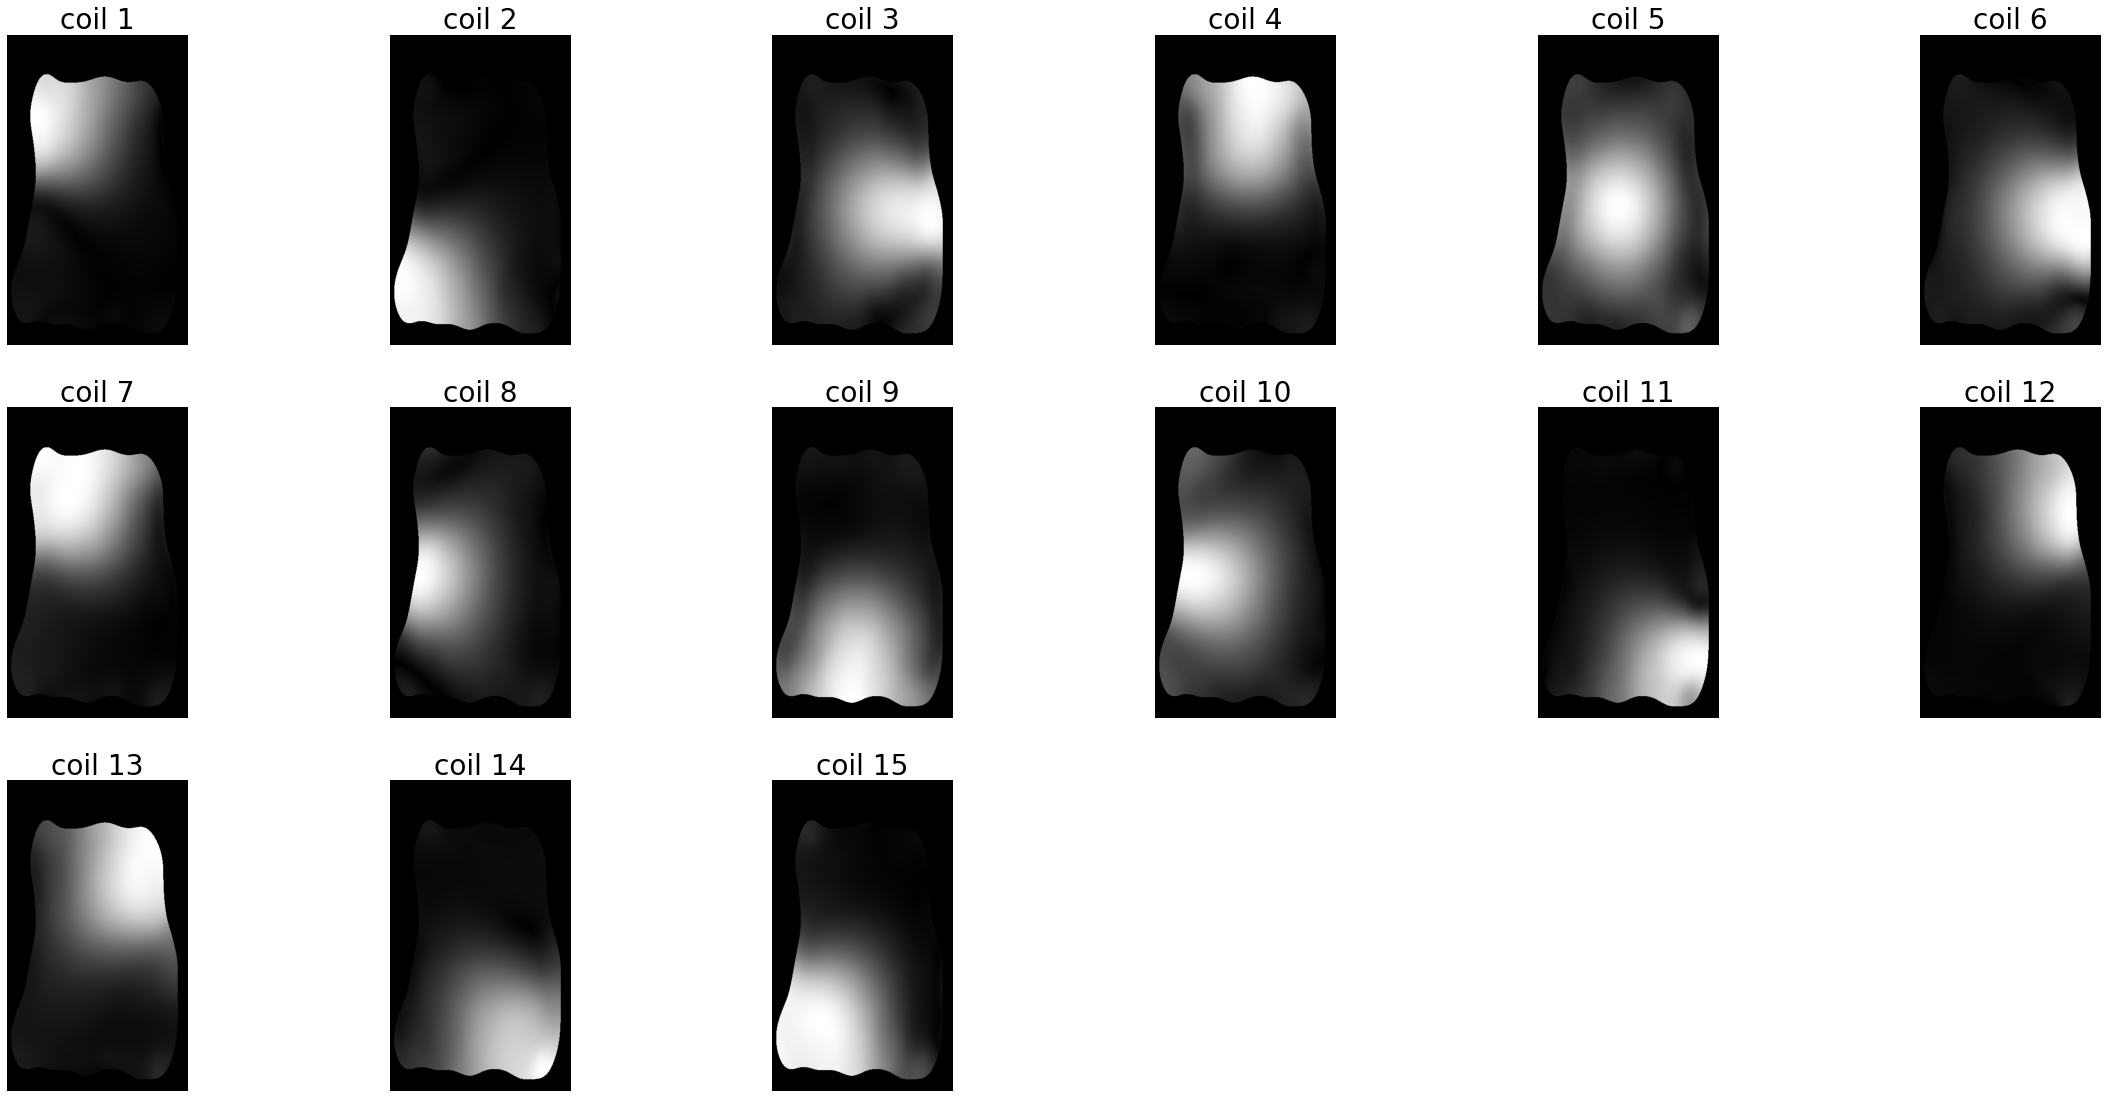

In [81]:
### load the knee training set and the under-sampling mask
with open('./train_data/knee_train','rb') as fn:
    dataset = pickle.load(fn)
with open('./train_data/knee_mask','rb') as fn:
    mask2d = pickle.load(fn)
data_dir = '/data/fastMRIdata/knee/multicoil_train/'

sens_maps = compute_sens_maps(dataset, mask2d, data_dir)